In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/My Drive/Biomedical Image Processing ED6001/Biomedical Project/Final Submission

[Errno 2] No such file or directory: '/gdrive/My Drive/Biomedical Image Processing ED6001/Biomedical Project/Final Submission'
/content


In [ ]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import cv2
import math
import matplotlib.image as mpimg
from google.colab import files

In [ ]:


filename = "/gdrive/My Drive/Biomedical Image Processing ED6001/Biomedical Project/Data set/mws_data_isbi/isbi_train_volume.h5"
with h5py.File(filename, "r") as infile:
  base_items=list(infile.items())
  print("Items in base directory:", base_items)
  labels=infile.get('labels')
  label_item=list(labels.items())
  print("items in labels:", label_item)
  raw = infile["raw"][:]
  affs = infile["affinities"][:]
  gt=labels["gt_segmentation"][:]
  membranes=labels["membrabes"][:]

Items in base directory: [('affinities', <HDF5 dataset "affinities": shape (17, 30, 512, 512), type "<f4">), ('labels', <HDF5 group "/labels" (2 members)>), ('raw', <HDF5 dataset "raw": shape (30, 512, 512), type "<f4">)]
items in labels: [('gt_segmentation', <HDF5 dataset "gt_segmentation": shape (30, 512, 512), type "<u8">), ('membrabes', <HDF5 dataset "membrabes": shape (30, 512, 512), type "<f4">)]


Enter the image no between 0 to 29 to be preprocessed0


(<matplotlib.image.AxesImage at 0x7f4da8727cf8>,
 Text(0.5, 1.0, 'OriginalImage'))

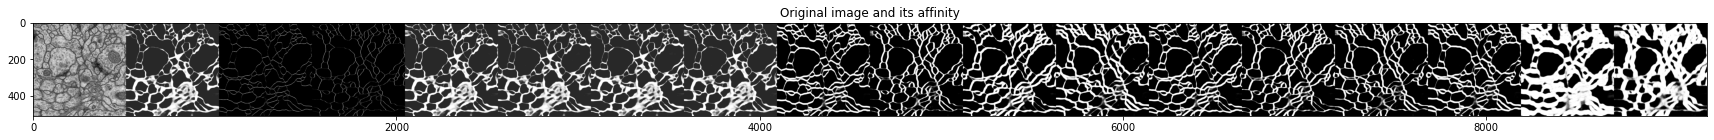

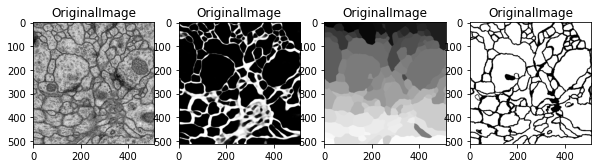

In [ ]:
img_no=input('Enter the image no between 0 to 29 to be preprocessed')
img_no=int(img_no)
fig1 = plt.figure(figsize=(30,20))
plt.imshow(np.concatenate((raw[img_no], ) + tuple(affs[c, img_no] for c in range(len(affs))), axis=1), cmap='gray'),plt.title('Original image and its affinity')
fig2 = plt.figure(figsize=(10,10))
plt.subplot(141).imshow(raw[img_no],cmap='gray'),plt.title('OriginalImage')
plt.subplot(142).imshow(affs[0][img_no],cmap='gray'),plt.title('OriginalImage')
plt.subplot(143).imshow(gt[img_no],cmap='gray'),plt.title('OriginalImage')
plt.subplot(144).imshow(membranes[img_no],cmap='gray'),plt.title('OriginalImage')

In [ ]:
def imshow(img):
    if len(img.shape) < 3:
        plt.imshow(img, cmap="gray")
    elif img.shape[2] == 1:
        plt.imshow(np.resize(img,(img.shape[0],img.shape[1])), cmap="gray")
    else:
        plt.imshow(img)

Gamma Correction

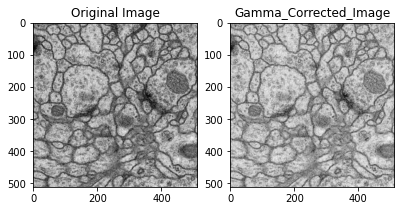

In [ ]:
# Gamma Coorection
def gammaCorrection(img, gamma):
    out = np.power(img.copy(), gamma)
    return out
gamma_corrected=gammaCorrection(raw[img_no],0.7)


display = [raw[img_no],gamma_corrected]
label = ['Original Image', 'Gamma_Corrected_Image']
fig1 = plt.figure(figsize=(10,10))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig1.add_subplot(2,3, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

# images_dir = 'Output/op%d'%int(img_no+1)
# fig1.savefig("Results/EM preprocessing/gamma_%d.png"%int(img_no+1))

# files.download("Results/EM preprocessing/gamma_%d.png"%int(img_no+1))


#cv2.imwrite("Results/EM preprocessing/gamma.jpg",gamma_corrected)

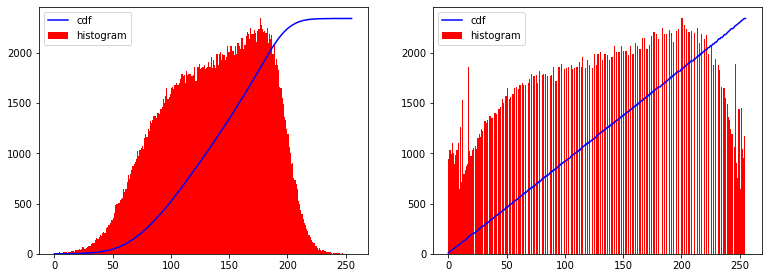

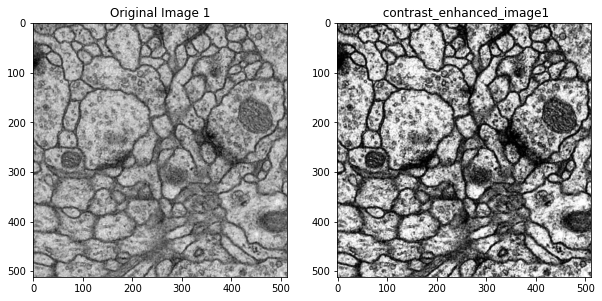

In [ ]:
img=np.uint(raw[img_no]*255)
grey_levels, count = np.unique(img, return_counts=True)
H = np.zeros((256,1))
for i in range(0,len(grey_levels)):
    H[grey_levels[i],0]=count[i]
cdf=[sum(H[:i+1]) for i in range(len(H))]
cdf=np.concatenate( cdf, axis=0 )
# print(cdf)
cdf_normalized = cdf * H.max()/ cdf.max()
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(img.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.show()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m= (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

img_enhanced = cdf[img]
grey_levels_2, count_2 = np.unique(img_enhanced, return_counts=True)
H_2 = np.zeros((256,1))
for i in range(0,len(grey_levels_2)):
    H_2[grey_levels_2[i],0]=count_2[i]
cdf_2=[sum(H_2[:i+1]) for i in range(len(H_2))]
cdf_2=np.concatenate( cdf_2, axis=0 )
# print(cdf)
cdf_normalized_2 = cdf_2 * H_2.max()/ cdf_2.max()
fg = plt.figure("Regularised labeling",figsize=(20,10))
ax1 = fg.add_subplot(2,3,1)
ax1.plot(cdf_normalized, color = 'b')
ax1.hist(img.flatten(),256,[0,256], color = 'r')
#ax1.xlim([0,256])
ax1.legend(('cdf','histogram'), loc = 'upper left')
#plt.show()
ax2 = fg.add_subplot(2,3,2)
ax2.plot(cdf_normalized_2, color = 'b')
ax2.hist(img_enhanced.flatten(),256,[0,256], color = 'r')
#ax2.xlim([0,256])
ax2.legend(('cdf','histogram'), loc = 'upper left')
#plt.show()


display = [img, img_enhanced  ]
label = ['Original Image %d'%int(img_no+1), ' contrast_enhanced_image%d'%int(img_no+1)]

fig = plt.figure(figsize=(10,15))

for i in range(len(display)):
  fig.add_subplot(2, 2, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])
plt.show()

Low pass, High Pass and Gaussian filter

In [ ]:
# low pass filter
(lpfw,lpfh) = (3,3)
lowPassFilter = np.ones((lpfw,lpfh))*1/(lpfw*lpfh)


# high pass filter
(hpfw,hpfh) = (3,3)
highPassFilter = -1*np.ones((hpfw,hpfh))
highPassFilter[hpfw//2,hpfh//2] = -np.sum(highPassFilter)-1


# gaussian filter
def gfunc(x,y,sigma):
    return (math.exp(-(x**2 + y**2)/(2*(sigma**2))))/(2*3.14*(sigma**2))

def gaussFilter(size, sigma):
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = gfunc(i-size[0]//2,j-size[1]//2, sigma )
    return out/np.sum(out)

(gfw,gfh) = (3,3)
gaussianFilter = gaussFilter((gfw,gfh),1)

print("Low Pass Filter")
print(lowPassFilter)

print("High Pass Filter")
print(highPassFilter)

print("Gaussian Filter")
print(gaussianFilter)

Low Pass Filter
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
High Pass Filter
[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]
Gaussian Filter
[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


In [ ]:
len(gamma_corrected.shape)

2

 ========================================= Low Pass Filter =========================================


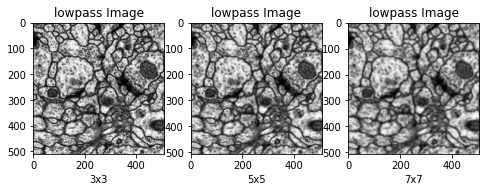

In [ ]:
def conv(image, filter):
    if len(image.shape)==3:
      iw,ih,id = image.shape
    elif len(image.shape)==2:
      iw,ih = image.shape
      id =1
    fw,fh = filter.shape    
    out = np.zeros((iw-fw+1,ih-fh+1,id))
    if len(image.shape)==3:
        for d in range(id):
            for w in range(ih-fh+1):
                for h in range(iw-fw+1):
                    out[w,h,d] = np.sum(filter*image[w:w+fh , h:h+fw , d])
    if len(image.shape)==2:
            for w in range(ih-fh+1):
                for h in range(iw-fw+1):
                    out[w,h] = np.sum(filter*image[w:w+fh , h:h+fw])
        
    if id == 1:
        return np.resize(out, (out.shape[0], out.shape[1]))
    else:
        return out

    


fig = plt.figure(1, figsize=(8, 10))
print(" ========================================= Low Pass Filter =========================================")
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    (lpfw,lpfh) = (i,i)
    lowPassFilter = np.ones((lpfw,lpfh))*1/(lpfw*lpfh)
    low_image = conv(img_enhanced, lowPassFilter)
    imshow(low_image),plt.title('lowpass Image')
    cv2.imwrite("low"+str(i)+"x"+str(i)+".jpg",low_image)    
plt.show()

print()

    
#fig1.savefig("Results/EM preprocessing/lowpass_%d.png"%int(img_no+1))

#files.download("Results/EM preprocessing/gaussian_%d.png"%int(img_no+1))

 ========================================= Gaussian Filter =========================================


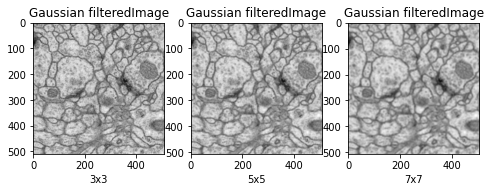

In [ ]:

fig = plt.figure(2, figsize=(8, 10))
Gaussianlist=[]
print(" ========================================= Gaussian Filter =========================================")
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    (gfw,gfh) = (i,i)
    gaussianFilter = gaussFilter((gfw,gfh),4)
    gaussian_image = conv(gamma_corrected, gaussianFilter)
    Gaussianlist.append(gaussian_image),plt.title('Gaussian filteredImage')
    imshow(gaussian_image)
    #cv2.imwrite("gaussian"+str(i)+"x"+str(i)+".jpg",gaussian_image)
    
# fig.savefig("Results/EM preprocessing/Gaussian_%d.png"%int(img_no+1))



 ========================================= Gaussian Filter =========================================


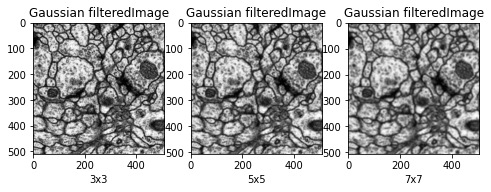

In [ ]:
fig = plt.figure(2, figsize=(8, 10))
Gaussianlist_2=[]
print(" ========================================= Gaussian Filter =========================================")
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    (gfw,gfh) = (i,i)
    gaussianFilter = gaussFilter((gfw,gfh),4)
    gaussian_image_2 = conv(img_enhanced, gaussianFilter)
    Gaussianlist_2.append(gaussian_image_2),plt.title('Gaussian filteredImage')
    imshow(gaussian_image_2)

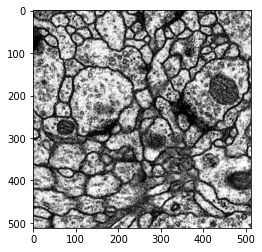

In [ ]:
plt.imshow(img_enhanced,cmap='gray')

Bilateral Filter

Parameters:

i,j: pixel value for which bilateral filter will be applied
fw,fh: Filter width and filter height
image: input image on which pixel (i,j) exist
sigma1, sigma2: bilateral function parameters
bilaterealWFilter: weighted bilateral Filteral
bilateralFilterConv:
Function that apply convolution on given image with the bilateral filter of given size

Parameters:

image: input image on which bilateral filter will be applied
fw,fh: widht and height if bilateral filter
Return:

returns a bilateral filtered image (2d/3d matrix)

 ========================================= Bilateral Filter =========================================


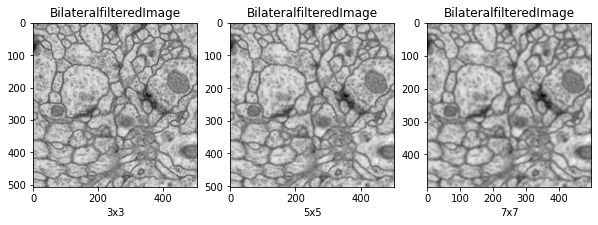

In [ ]:
# bilateral filter

def bfunc(i,j,fw,fh,image,sigma1, sigma2, bilateralWFilter):
    if len(image.shape) < 3  or image.shape[2] == 1:
      imgwork = image[i - fh//2:i+1 + fh//2, j - fw//2:j+1 + fw//2]
      
      bilateralIFilter = ((imgwork - image[i, j])**2 )/(2*(sigma1**2))
    else:
      imgwork = image[i - fh//2:i+1 + fh//2, j - fw//2:j+1 + fw//2, :]
      
      bilateralIFilter = ((imgwork - image[i, j,:])**2 )/(2*(sigma1**2))
    
    bilateralFilter = np.exp(-1*bilateralIFilter)*bilateralWFilter
    bilateralFilter = bilateralFilter/np.sum(bilateralFilter,axis=(0,1))
    return np.sum(np.multiply(imgwork, bilateralFilter),axis=(0,1))
image=np.copy(gamma_corrected)
def bilateralFilterConv(image, fw,fh):
    size = image.shape
    sigma1 = 40
    sigma2 = 40
    bilateral1 = 2*3.14*sigma2*sigma2*gaussFilter((fw,fh), sigma2)
    #print(bilateral1.shape)
    if len(image.shape) < 3  or image.shape[2] == 1:
        bilateralWFilter = np.resize(bilateral1,(bilateral1.shape))
        out = np.zeros((size[0]-2*fw +1,size[1]-2*fh +1))
        #print(bilateralWFilter.shape)
    else:
        bilateralWFilter = np.stack([bilateral1, bilateral1, bilateral1], axis=2)
        out = np.zeros((size[0]-2*fw +1,size[1]-2*fh +1,size[2]))
    
    
    for i in range(size[0]-2*fh +1):
        for j in range(size[1]-2*fw +1):
            out[i,j] = bfunc(i+fw-1, j+fh-1, fw, fh, image, sigma1, sigma2, bilateralWFilter)

    # if id == 1:
    #     return np.resize(out, (out.shape[0], out.shape[1]))
    # else:
    return out


    
fig = plt.figure(1, figsize=(10, 16))
bilaterallist=[]
print(" ========================================= Bilateral Filter =========================================")
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    #imshow(raw[0],cmap='gray')
    splot.set_xlabel(str(i)+"x"+str(i))
    bfw,bfh = (i,i)
    bilateral_image = bilateralFilterConv(gamma_corrected, bfw,bfh)
    bilaterallist.append(bilateral_image)
    imshow(bilateral_image) ,plt.title('BilateralfilteredImage')
#     cv2.imwrite("bilateral"+str(i)+"x"+str(i)+".jpg",bilateral_image)    
plt.show()
# fig.savefig("Results/EM preprocessing/Bilateral_%d.png"%int(img_no+1))

 ========================================= Bilateral Filter =========================================


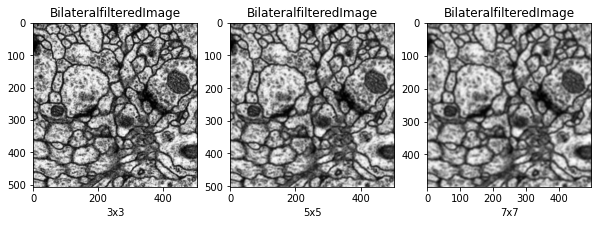

In [ ]:
fig = plt.figure(1, figsize=(10, 16))
bilaterallist_2=[]
print(" ========================================= Bilateral Filter =========================================")
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    #imshow(raw[0],cmap='gray')
    splot.set_xlabel(str(i)+"x"+str(i))
    bfw,bfh = (i,i)
    bilateral_image_2 = bilateralFilterConv(img_enhanced, bfw,bfh)
    bilaterallist_2.append(bilateral_image_2)
    imshow(bilateral_image_2) ,plt.title('BilateralfilteredImage')
#     cv2.imwrite("bilateral"+str(i)+"x"+str(i)+".jpg",bilateral_image)    
plt.show()
#fig.savefig("Results/EM preprocessing/Bilateral_%d.png"%int(img_no+1))

Non local mean filtering

nlmFilterConv:
Function that apply convolution on given image with the NLM filter of given size.

Parameters:

image: input image on which NLM filter will be applied
nw,nh: neighbour width and height
fw,fh: widht and height if NLM filter
Return:

returns a NLM filtered image (2d/3d matrix)

 ========================================= NLM Filter =========================================


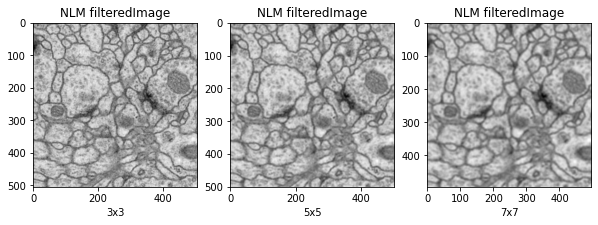

In [ ]:
# Non Local Mean filter

def nlmfunc(i, j, fw, fh, nw, nh ,image,sigma1, sigma2, nlmWFilter):
    imgmain = image[i - fh//2:i+1 + fh//2, j - fw//2:j+1 + fw//2]
    
    nlmFilter = 0
    for p in range(-(nh//2), 1+(nh//2)):
        for q in range(-(nw//2), 1+(nw//2)):
            imgneighbour = image[i + p - fh//2: i+1+p + fh//2, j+q - fw//2:j+1+q + fw//2]
            nlmIFilter = ((imgmain - imgneighbour)**2 )/(2*(sigma1**2))
            nlmFilter += np.exp(-1*nlmIFilter)
            
    nlmFilter = nlmFilter/np.sum(nlmFilter,axis=(0,1))
    nlmFilter = nlmFilter*nlmWFilter
    nlmFilter = nlmFilter/np.sum(nlmFilter,axis=(0,1))
    return np.sum(np.multiply(imgmain, nlmFilter),axis=(0,1))

def nlmFilterConv(image, fw,fh, nw, nh):
    size = image.shape
    sigma1 = 20
    sigma2 = 20
    nlmWFilter1 = 2*3.14*sigma2*sigma2*gaussFilter((fw,fh), sigma2)
    if len(image.shape) < 3  or image.shape[2] == 1:
        nlmWFilter = np.resize(nlmWFilter1,(nlmWFilter1.shape))
        out = np.zeros((size[0]-2*fw +1-nw//2,size[1]-2*fh +1-nh//2))
    else:
        nlmWFilter = np.stack([nlmWFilter1, nlmWFilter1, nlmWFilter1], axis=2)    
        out = np.zeros((size[0]-2*fw +1-nw//2,size[1]-2*fh +1-nh//2, size[2]))
    
    for i in range(nh//2, size[0]-2*fh +1-nh//2):
        for j in range(nw//2, size[1]-2*fw +1- nw//2):
            out[i,j] = nlmfunc(i+fw-1, j+fh-1, fw, fh, nw, nh, image, sigma1, sigma2, nlmWFilter)
        
    out[0:nh//2,:] = out[nh//2,:]
    out[:,0:nw//2] = out[:,nw//2,np.newaxis]
    # if id == 1:
    #     return np.resize(out, (out.shape[0], out.shape[1]))#.astype(np.uint8)
    # else:
    #     return out.astype(np.uint8)

    return np.resize(out, (out.shape[0], out.shape[1]))
    
fig = plt.figure(1, figsize=(10, 16))
print(" ========================================= NLM Filter =========================================")
nlmlist=[]
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    nlmfw,nlmfh = (i,i)
    nlm_image = nlmFilterConv(gamma_corrected, nlmfw,nlmfh, i, i)
    #nlm_image=np.resize(nlm_image, (gamma_corrected.shape[0], gamma_corrected.shape[1]))
    nlmlist.append(nlm_image)
    imshow(nlm_image),plt.title('NLM filteredImage')
    #cv2.imwrite("nlm"+str(i)+"x"+str(i)+".jpg",nlm_image)
plt.show()
#fig.savefig("Results/EM preprocessing/NLM_%d.png"%int(img_no+1))

 ========================================= NLM Filter =========================================


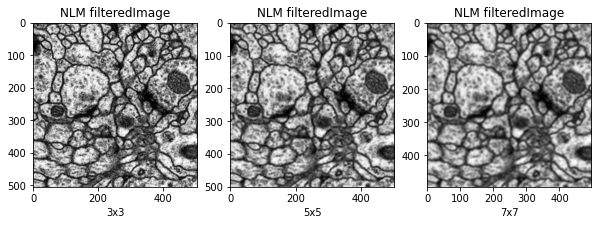

In [ ]:
fig = plt.figure(1, figsize=(10, 16))
print(" ========================================= NLM Filter =========================================")
nlmlist_2=[]
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    nlmfw,nlmfh = (i,i)
    nlm_image_2 = nlmFilterConv(img_enhanced, nlmfw,nlmfh, i, i)
    #nlm_image=np.resize(nlm_image, (gamma_corrected.shape[0], gamma_corrected.shape[1]))
    nlmlist_2.append(nlm_image_2)
    imshow(nlm_image_2),plt.title('NLM filteredImage')
    #cv2.imwrite("nlm"+str(i)+"x"+str(i)+".jpg",nlm_image_2)
plt.show()
#fig.savefig("Results/EM preprocessing/NLM_%d.png"%int(img_no+1))

In [ ]:
#blur = cv2.bilateralFilter(bi_noised_img,5,20,25)

Comparision Results

In [ ]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


In [2]:
#PSNR
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [ ]:
Gaussianlist[0].shape

(510, 510)

In [1]:
#Psnr for Original Image with different filter  with kernel 3x3
psnr_Gaussian=calculate_psnr(255*crop_center(raw[img_no],Gaussianlist[0].shape[0],Gaussianlist[0].shape[1]), 255*Gaussianlist[0], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(raw[img_no],bilaterallist[0].shape[0],bilaterallist[0].shape[1]), 255*bilaterallist[0], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(raw[img_no],nlmlist[0].shape[0],nlmlist[0].shape[1]), 255*nlmlist[0], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

NameError: ignored

In [ ]:
#Psnr for Gammaa correct Image with different filter  with kernel 3x3
psnr_Gaussian=calculate_psnr(255*crop_center(gamma_corrected,Gaussianlist[0].shape[0],Gaussianlist[0].shape[1]), 255*Gaussianlist[0], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(gamma_corrected,bilaterallist[0].shape[0],bilaterallist[0].shape[1]), 255*bilaterallist[0], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(gamma_corrected,nlmlist[0].shape[0],nlmlist[0].shape[1]), 255*nlmlist[0], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: 30.120107851239624
psnr_Bilateral: 23.180543563071907
psnr_NLM: 23.18594507124242


In [ ]:
#Psnr for Histgram Equalisaiton Image with different filter  with kernel 3x3
psnr_Gaussian=calculate_psnr(255*crop_center(img_enhanced,Gaussianlist_2[0].shape[0],Gaussianlist_2[0].shape[1]), 255*Gaussianlist_2[0], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(img_enhanced,bilaterallist_2[0].shape[0],bilaterallist_2[0].shape[1]), 255*bilaterallist_2[0], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(img_enhanced,nlmlist_2[0].shape[0],nlmlist_2[0].shape[1]), 255*nlmlist_2[0], max_value=255)
print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: -43.16312135577712
psnr_Bilateral: -43.1715435294954
psnr_NLM: -43.170619014041876


In [ ]:
#Psnr for Original Image with different filter  with kernel 5x5

psnr_Gaussian=calculate_psnr(255*crop_center(gamma_corrected,Gaussianlist[1].shape[0],Gaussianlist[1].shape[1]), 255*Gaussianlist[1], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(gamma_corrected,bilaterallist[1].shape[0],bilaterallist[1].shape[1]), 255*bilaterallist[1], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(gamma_corrected,nlmlist[1].shape[0],nlmlist[1].shape[1]), 255*nlmlist[1], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: 25.21491249722159
psnr_Bilateral: 23.065058624251257
psnr_NLM: 20.21556313269697


In [ ]:
#Psnr for Original Image with different filter  with kernel 5x5

psnr_Gaussian=calculate_psnr(255*crop_center(raw[img_no],Gaussianlist[1].shape[0],Gaussianlist[1].shape[1]), 255*Gaussianlist[1], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(raw[img_no],bilaterallist[1].shape[0],bilaterallist[1].shape[1]), 255*bilaterallist[1], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(raw[img_no],nlmlist[1].shape[0],nlmlist[1].shape[1]), 255*nlmlist[1], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: 18.129156271228414
psnr_Bilateral: 17.54584159958918
psnr_NLM: 16.420028846597994


In [ ]:
#Psnr for Histgram Equalisaiton Image with different filter  with kernel 5x5
psnr_Gaussian=calculate_psnr(255*crop_center(raw[img_no],Gaussianlist_2[1].shape[0],Gaussianlist_2[1].shape[1]), 255*Gaussianlist_2[1], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(img_enhanced,bilaterallist_2[1].shape[0],bilaterallist_2[1].shape[1]), 255*bilaterallist_2[1], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(img_enhanced,nlmlist_2[1].shape[0],nlmlist_2[1].shape[1]), 255*nlmlist_2[1], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: -43.007350713244335
psnr_Bilateral: -43.00714930120157
psnr_NLM: -43.004575710110096


In [ ]:
#Psnr for Original Image with different filter  with kernel 7x7
psnr_Gaussian=calculate_psnr(255*crop_center(gamma_corrected,Gaussianlist[2].shape[0],Gaussianlist[2].shape[1]), 255*Gaussianlist[2], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(gamma_corrected,bilaterallist[2].shape[0],bilaterallist[2].shape[1]), 255*bilaterallist[2], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(gamma_corrected,nlmlist[2].shape[0],nlmlist[2].shape[1]), 255*nlmlist[2], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: 23.249402896475058
psnr_Bilateral: 22.146989857206574
psnr_NLM: 20.589659099314556


In [ ]:
#Psnr for Original Image with different filter  with kernel 7x7
psnr_Gaussian=calculate_psnr(255*crop_center(raw[img_no],Gaussianlist[2].shape[0],Gaussianlist[2].shape[1]), 255*Gaussianlist[2], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(raw[img_no],bilaterallist[2].shape[0],bilaterallist[2].shape[1]), 255*bilaterallist[2], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(raw[img_no],nlmlist[2].shape[0],nlmlist[2].shape[1]), 255*nlmlist[2], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: 17.534573320341096
psnr_Bilateral: 17.162584467324642
psnr_NLM: 16.534934618238363


In [ ]:
#Psnr for Hist enhance Image with different filter  with kernel 7x7
psnr_Gaussian=calculate_psnr(255*crop_center(img_enhanced,Gaussianlist[2].shape[0],Gaussianlist[2].shape[1]), 255*Gaussianlist[2], max_value=255)
psnr_Bilateral=calculate_psnr(255*crop_center(img_enhanced,bilaterallist[2].shape[0],bilaterallist[2].shape[1]), 255*bilaterallist[2], max_value=255)
psnr_NLM=calculate_psnr(255*crop_center(img_enhanced,nlmlist[2].shape[0],nlmlist[2].shape[1]), 255*nlmlist[2], max_value=255)

print('PSNR values for different filtered image:')
print('psnr_Gaussian: {}'.format(psnr_Gaussian))
print('psnr_Bilateral: {}'.format(psnr_Bilateral))
print('psnr_NLM: {}'.format(psnr_NLM))

PSNR values for different filtered image:
psnr_Gaussian: 7.647355786945917
psnr_Bilateral: 7.7453628074392755
psnr_NLM: 7.884355425054814


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise


# astro = img_as_float(data.astronaut())
# astro = astro[30:180, 150:300]

sigma = 0.08
# noisy = random_noise(astro, var=sigma**2)

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(gamma_corrected, multichannel=True))
print(f"estimated noise standard deviation = {sigma_est}")

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

# # slow algorithm
# denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False,
#                            **patch_kw)

# # slow algorithm, sigma provided
# denoise2 = denoise_nl_means(noisy, h=0.8 * sigma_est, sigma=sigma_est,
#                             fast_mode=False, **patch_kw)

# fast algorithm
denoise_fast = denoise_nl_means(gamma_corrected, h=0.8 * sigma_est, fast_mode=True,
                                **patch_kw)

estimated noise standard deviation = 0.02924203022111798


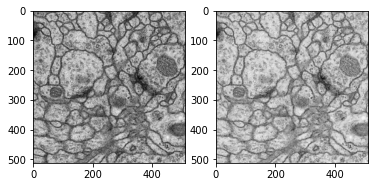

In [ ]:
plt.subplot(121).imshow(raw[0],cmap='gray')
plt.subplot(122).imshow(denoise_fast,cmap='gray')

In [ ]:
psnr_fast = peak_signal_noise_ratio(raw[0], denoise_fast)
print(f"PSNR (fast) = {psnr_fast:0.2f}")

PSNR (fast) = 19.48


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.
